## Loading File

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
import os


# Load the CSV file
base_dir = "/Users/zac/Codes/Music_Project/GIT_HUB/Musis_Recommendation_Engine"
file_path = 'exploration/Data_collection/final_filtered_mood_list.csv'
df = pd.read_csv(os.path.join(base_dir,file_path))

# Remove duplicates
df = df.drop_duplicates()
df_temp = df

## Model Fit

In [160]:

df_new = df 

# Fit the scaler specifically for the tempo column
tempo_scaler = StandardScaler()
df['tempo'] = tempo_scaler.fit_transform(df[['tempo']])

# Normalize numerical features
numerical_features = ['duration_ms', 'popularity', 'danceability', 'energy', 'loudness', 
                      'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
                      'valence', 'tempo']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Encode the 'mood' as a categorical feature
label_encoder = LabelEncoder()
df['mood_encoded'] = label_encoder.fit_transform(df['mood'])

# Define the features for the k-NN model
features = ['duration_ms', 'popularity', 'danceability', 'energy', 'loudness',
            'speechiness', 'acousticness', 'instrumentalness', 'liveness',
            'valence', 'tempo', 'mood_encoded']

# Train the k-NN model
knn_model = NearestNeighbors(n_neighbors=5, metric='manhattan', leaf_size=30, )  # euclidean
knn_model.fit(df[features])


NearestNeighbors(metric='manhattan')

## Hyper-parameter search for K-NN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the features for the k-NN model
features = ['duration_ms', 'popularity', 'danceability', 'energy', 'loudness',
            'speechiness', 'acousticness', 'instrumentalness', 'liveness',
            'valence', 'tempo', 'mood_encoded']

# Specify hyperparameters for grid search
param_grid = {
    'n_neighbors': [5, 10, 15],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 40, 50]
}

# Create k-NN model
knn = KNeighborsClassifier()

# Grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(df[features], df['mood'])  # Make sure to replace 'target_column' with your target variable

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the k-NN model with the best parameters
best_knn_model = KNeighborsClassifier(**best_params)
best_knn_model.fit(df[features], df['mood'])  # Make sure to replace 'target_column' with your target variable


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 5}


/Users/zac/anaconda3/envs/model_music/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zac/anaconda3/envs/model_music/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zac/anaconda3/envs/model_music/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zac/anaconda3/envs/model_music/lib/python3.11/site-packages/sklearn/base.py", line 705, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/Users/zac/anaconda3/envs/model_music/lib/python3.1

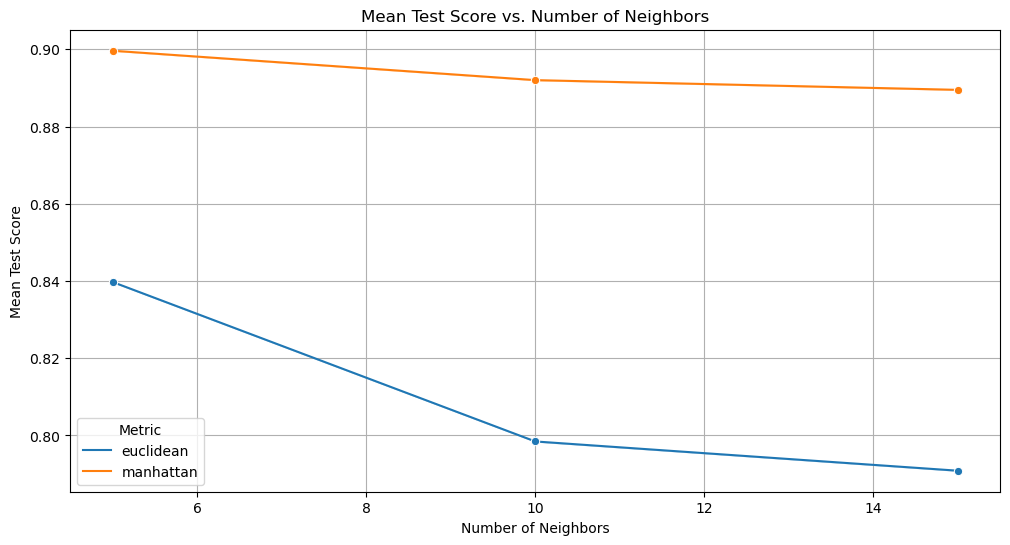

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract results of grid search
results = pd.DataFrame(grid_search.cv_results_)

# Plot the performance of different hyperparameter combinations
plt.figure(figsize=(12, 6))
sns.lineplot(x='param_n_neighbors', y='mean_test_score', hue='param_metric', data=results, marker='o')
plt.title('Mean Test Score vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.legend(title='Metric')
plt.grid(True)
plt.show()


## Model Inference

In [31]:

# Recommendation function
def recommend_songs(mood, year_range=[2000, 2005], tempo_range=None, exclude_artists=None, randomize=None, n_recommendations=10, deviation=0.5):
    mood_encoded = label_encoder.transform([mood])[0]
    filtered_df = df[df['mood_encoded'] == mood_encoded]
    
    if year_range:
        # filtered_df = filtered_df[(filtered_df['year'] >= year_range[0]) & (filtered_df['year'] <= year_range[1])]
        filtered_df = filtered_df[(filtered_df['year'] >= 2000) & (filtered_df['year'] <= 2008)]
    if tempo_range:
        filtered_df = filtered_df[(filtered_df['tempo'] >= tempo_range[0]) & (filtered_df['tempo'] <= tempo_range[1])]
    
    if exclude_artists:
        filtered_df = filtered_df[~filtered_df['artist_name'].isin(exclude_artists)]
    
    if filtered_df.empty:
        filtered_df = df[df['mood_encoded'] == mood_encoded]
    
    weights = [1] * len(features)
    weights = [weight * (1 + deviation) for weight in weights]
    adjusted_features = filtered_df[features] * weights
    
    if randomize:
        recommendations = filtered_df.sample(n=n_recommendations)
    else:
        knn_distances, knn_indices = knn_model.kneighbors(adjusted_features, n_neighbors=n_recommendations)
        recommendations = df.iloc[knn_indices[0]]
    
    return recommendations[['artist_name', 'track_name', 'year', 'tempo', 'mood']].to_dict(orient='records')


# Test the recommendation function
recommendations = recommend_songs(mood='HAPPY', year_range=[2000, 2005], tempo_range=[100, 120], exclude_artists=['Eminem'], randomize=False, n_recommendations=5)
print(recommendations)


[{'artist_name': 'Timbaland', 'track_name': 'The Way I Are', 'year': 2007, 'tempo': -0.15538734278983865, 'mood': 'HAPPY'}, {'artist_name': 'Yot Club', 'track_name': 'no way !', 'year': 2019, 'tempo': 0.3885643081973462, 'mood': 'SCARED'}, {'artist_name': 'Timbaland', 'track_name': 'The Way I Are', 'year': 2023, 'tempo': -0.1569303685550011, 'mood': 'HAPPY'}, {'artist_name': 'Vishal Dadlani, Shalmali Kholgade', 'track_name': 'Balam Pichkari', 'year': 2013, 'tempo': 0.02907437368186487, 'mood': 'HAPPY'}, {'artist_name': 'Eyedress', 'track_name': 'Jealous', 'year': 2019, 'tempo': -0.9180979647562026, 'mood': 'SCARED'}]


In [162]:
def recommend_songs(mood, year_range=None, tempo_range=None, exclude_artists=None, randomize=None, n_recommendations=10, deviation=0.5):
    mood_encoded = label_encoder.transform([mood])[0]
    filtered_df = df[df['mood_encoded'] == mood_encoded]
    
    if year_range:
        filtered_df = filtered_df[(filtered_df['year'] >= year_range[0]) & (filtered_df['year'] <= year_range[1])]
    if tempo_range:
        normalized_tempo_range = tempo_scaler.transform([[tempo_range[0]], [tempo_range[1]]]).flatten()
        filtered_df = filtered_df[(filtered_df['tempo'] >= normalized_tempo_range[0]) & (filtered_df['tempo'] <= normalized_tempo_range[1])]
        # filtered_df = filtered_df[(filtered_df['tempo'] >= tempo_range[0]) & (filtered_df['tempo'] <= tempo_range[1])]
    if exclude_artists:
        filtered_df = filtered_df[~filtered_df['artist_name'].isin(exclude_artists)]
    
    if filtered_df.empty:
        filtered_df = df[df['mood_encoded'] == mood_encoded]

    # If the filtered_df is still empty, then return an empty recommendations list
    if filtered_df.empty:
        return []

    weights = [1] * len(features)
    weights = [weight * (1 + deviation) for weight in weights]
    adjusted_features = filtered_df[features] * weights
    
    if randomize:
        recommendations = filtered_df.sample(n=n_recommendations)
    else:
        knn_distances, knn_indices = knn_model.kneighbors(adjusted_features, n_neighbors=n_recommendations)
        recommendations = df.iloc[knn_indices[0]]
    
    return recommendations[['artist_name', 'track_name', 'year', 'tempo', 'mood']].to_dict(orient='records')

# Test the recommendation function
recommendations = recommend_songs(mood='HAPPY', year_range=[2000, 2005], tempo_range=[70, 130] ,exclude_artists=['Eminem'], randomize=True, n_recommendations=5)
print(recommendations)


[{'artist_name': 'Alka Yagnik', 'track_name': 'Kasam Khake Kaho', 'year': 2002, 'tempo': -0.18126809312370112, 'mood': 'HAPPY'}, {'artist_name': 'Young MC', 'track_name': 'Bust A Move', 'year': 2000, 'tempo': -0.05758055053896771, 'mood': 'HAPPY'}, {'artist_name': 'Sonu Nigam', 'track_name': 'Ada', 'year': 2005, 'tempo': -0.6734582434431604, 'mood': 'HAPPY'}, {'artist_name': 'Udit Narayan', 'track_name': 'Ek Dilruba Hai', 'year': 2005, 'tempo': 0.23938177172004077, 'mood': 'HAPPY'}, {'artist_name': '"Israel Kamakawiwo\'ole"', 'track_name': 'Over the Rainbow', 'year': 2001, 'tempo': -1.1779575311165302, 'mood': 'HAPPY'}]


/Users/zac/anaconda3/envs/model_music/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [163]:
tempo_scaler.transform([[130]])

/Users/zac/anaconda3/envs/model_music/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.37909574]])

In [164]:
tempo_scaler.transform([[100]])

/Users/zac/anaconda3/envs/model_music/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[-0.67296728]])